In [1]:
%matplotlib notebook

In [2]:
from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import os
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# os.path.abspath(os.path.join('..')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from scripts.util import extract_laser, undistort_camera


In [3]:
import glob, os

laser_samples = []
os.chdir("../res/laser_samples/")
for file in sorted(glob.glob("*")):
    laser_samples.append(file)

In [4]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
#     cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))

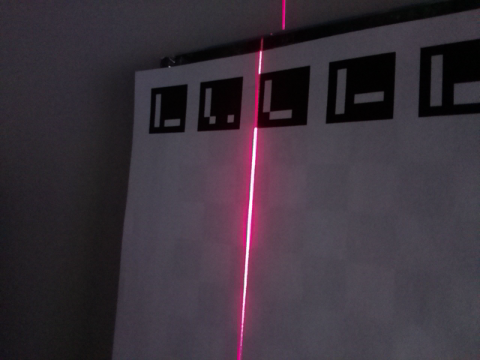

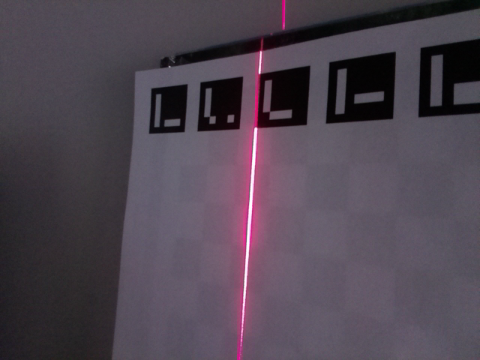

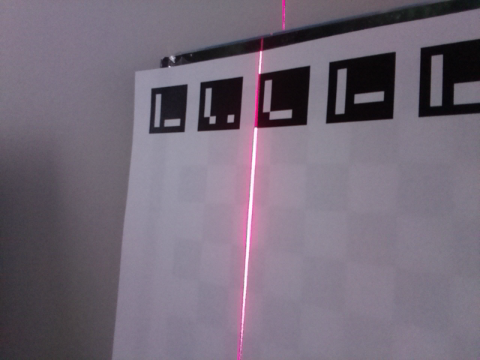

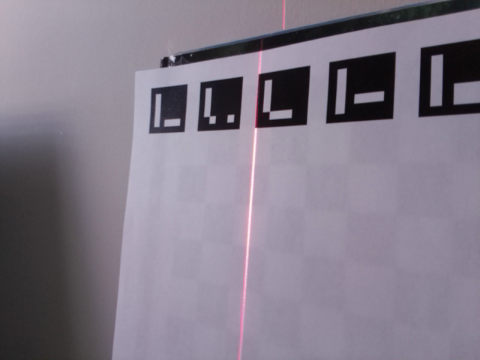

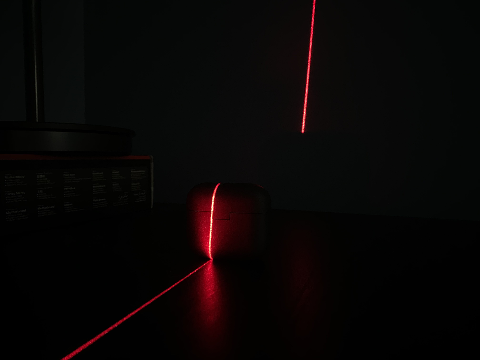

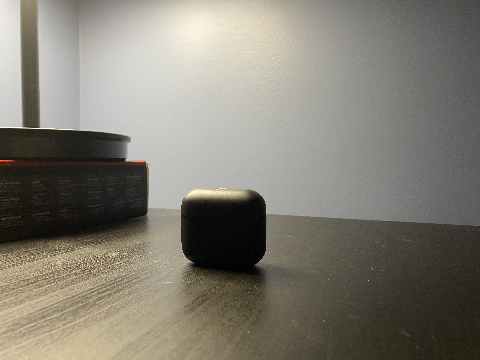

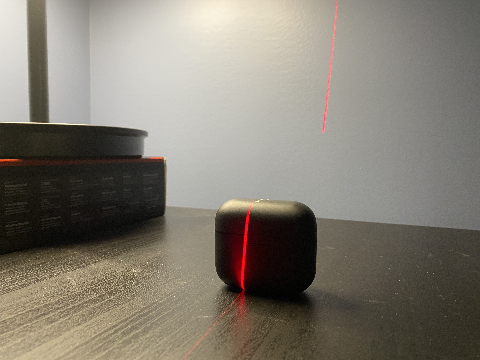

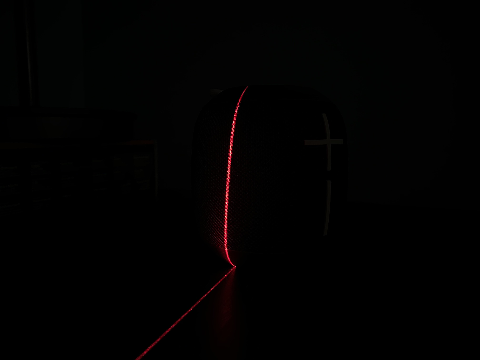

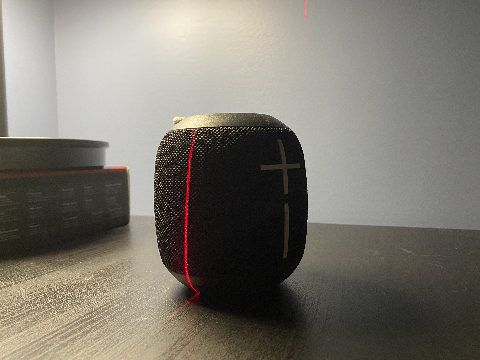

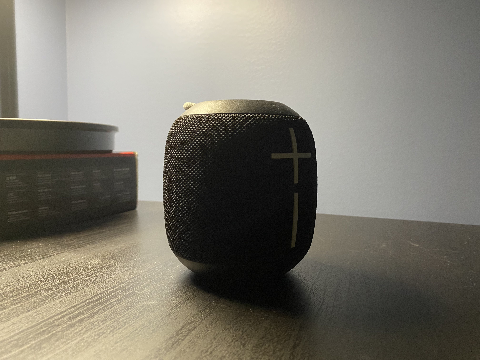

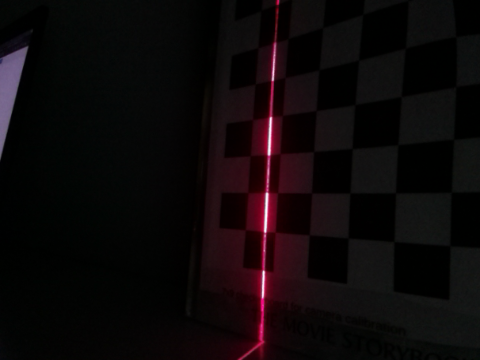

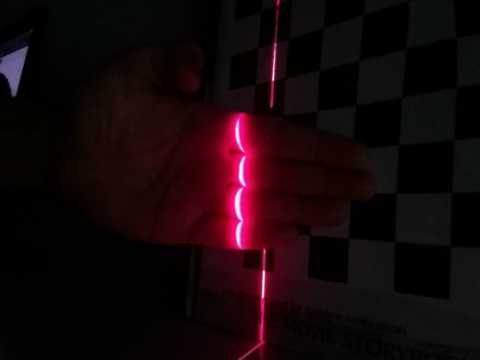

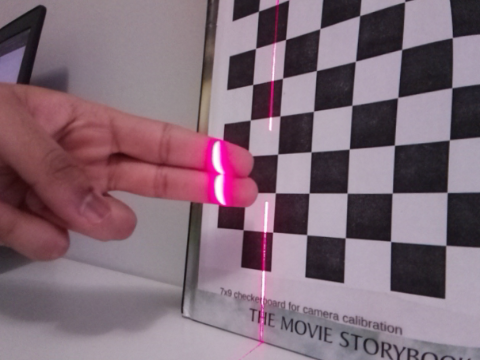

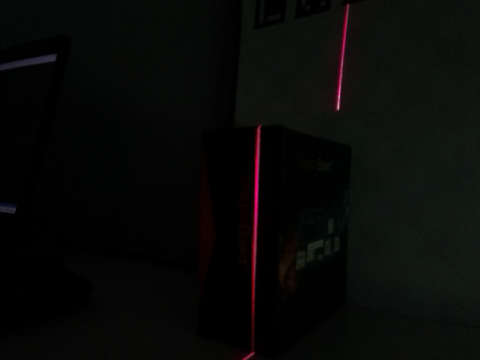

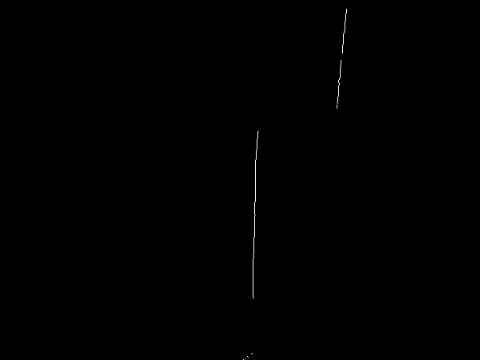

In [5]:
for f in laser_samples:
    disp_file(f)


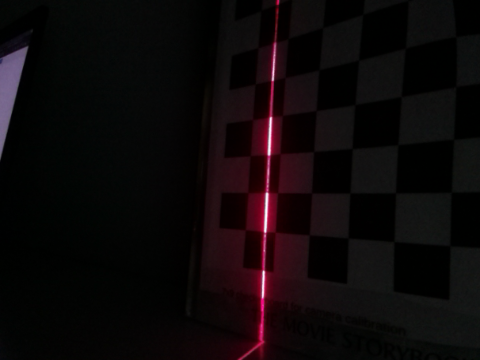

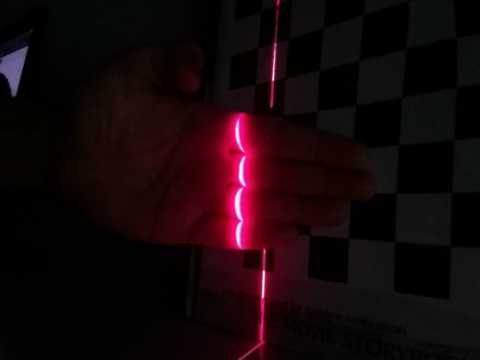

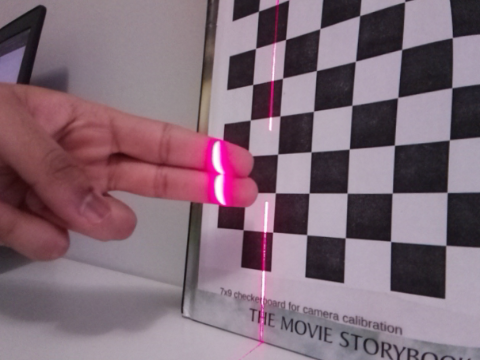

In [6]:
disp_file(laser_samples[10])
disp_file(laser_samples[11])
disp_file(laser_samples[12])

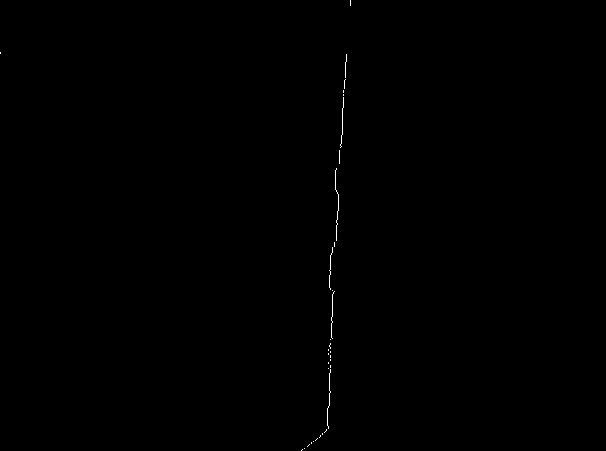

In [7]:
img = cv2.imread(laser_samples[10])
img1, POI1  = extract_laser(img)

display(Image.fromarray(img1))

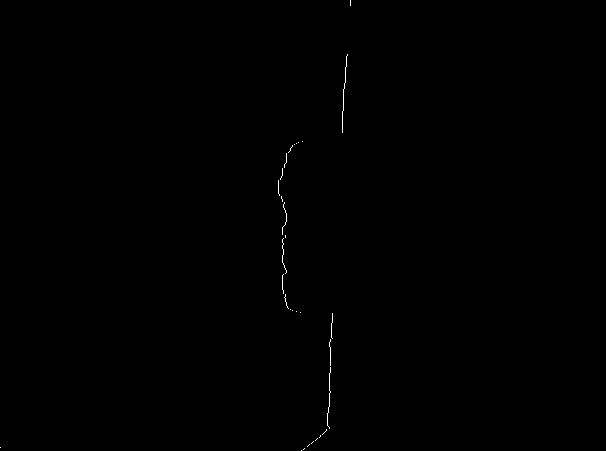

In [8]:
img = cv2.imread(laser_samples[11])
img, POI  = extract_laser(img)

display(Image.fromarray(img))

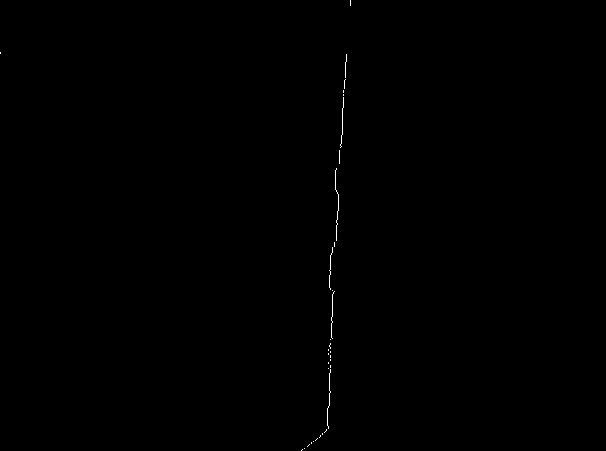

In [9]:
img_y_scale = cv2.imread(laser_samples[10])
img_y_scale, POI_y_scale  = extract_laser(img_y_scale)

display(Image.fromarray(img_y_scale))

In [11]:
os.chdir("../../")
# Load theta calibration parameters
with np.load('res/cal_theta_out/theta_params.npz') as X:
    theta_coeff = X['theta_coeff']

# Load camera calibration data from cam_out folder
with np.load('res/cal_out/cam_params.npz') as X:
    mtx, dist, rvecs, tvecs = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

In [12]:
%matplotlib notebook

from mpl_toolkits.mplot3d import axes3d   

# Obtain the width and height of the camera
h, w = img1.shape

# Get new camera matrix
new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print(new_mtx)
print(roi)

# dist b/w camera and laser is 4 in
X = 101.6
fx = new_mtx[0][0]
fy = new_mtx[1][1]

pix_size = 0.00000112 # in m

# Camera params
centre_x = int(w/2)
centre_y = int(h/2)

data = np.array([[0, 1, 2],[0, 0, 0],[2, 0, 2]])
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# # Plotting 
# from mpl_toolkits.mplot3d import proj3d

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x, y, z)
# plt.show()
        


[[494.31698608   0.         301.50573174]
 [  0.         494.52816772 257.62422274]
 [  0.           0.           1.        ]]
(10, 17, 586, 426)


# Triangulation Calculations

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, HBox

In [ ]:
@interact
def disp_pt_cloud(cam_angle=(20,80), y_scale=(0.1,1.0)):
    
    # Obtain the width and height of the camera
    h, w = img.shape

    # Get new camera matrix
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # dist b/w camera and laser is 4 in
    X = 101.6
#     cam_angle = 30
    
    fx = new_mtx[0][0]
    fy = new_mtx[1][1]
    f = int(0.5*(fx+fy))
        
    # Scale factor for y direction
    Y_SCALE = 1

    # Camera params
    centre_x = int(w/2)
    centre_y = int(h/2)

    b0 = X;
    C0 = cam_angle;

    POI_len = POI.shape[0]
    
    # L_PTS (pixel coordinates)
    l_pts = np.zeros((POI_len,3))
    l_pts[:,0] = POI - centre_x
    l_pts[:,1] = centre_y - np.arange(POI_len)
    l_pts[:,2] = 100
    
    x = l_pts[:, 0]
    y = l_pts[:, 1]
    z = l_pts[:, 2]

    
    # CAM_PTS (real world coordinates)
    #l_pts_t = l_pts.transpose()

    cam_pts = np.zeros((POI_len,3))
    
    delta_px_x0 = l_pts[:,0]
    A0 = 90 + np.degrees(np.arctan(delta_px_x0/f))
    B0 = 180 - (A0 + C0)
    a0 = (np.sin(np.deg2rad(A0))*b0)/np.sin(np.deg2rad(B0))    
    h1 = a0 * np.cos(np.arctan(delta_px_x0/f))
    
    cam_pts[:,2] = h1
    cam_pts[:,1] = l_pts[:,1] * y_scale
    cam_pts[:,0] = 0
    
    x_cam = cam_pts[:, 0]
    y_cam = cam_pts[:, 1]
    z_cam = cam_pts[:, 2]
    
    
    # Plotting 
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, color='#ff0000')
    
    ax.scatter(x_cam, y_cam, z_cam, color='#0000FF')
    
    plt.show()
    
#     return l_pts, cam_pts
        
# l_pts, cam_pts = disp_pt_cloud()



<IPython.core.display.Javascript object>


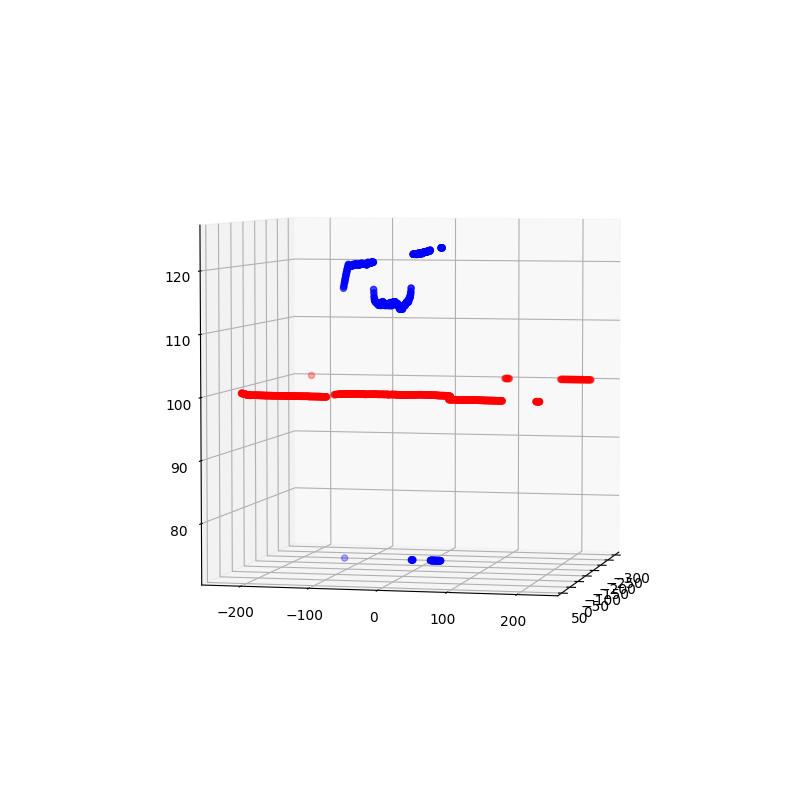

In [26]:
def disp_pt_cloud(img, POI):
    
    # Obtain the width and height of the camera
    h, w = img.shape

    # Get new camera matrix
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # dist b/w camera and laser is 4 in
    X = 101.6
    cam_angle = 30
    
    fx = new_mtx[0][0]
    fy = new_mtx[1][1]
    f = int(0.5*(fx+fy))
        
    # Scale factor for y direction
    Y_SCALE = 0.321

    # Camera params
    centre_x = int(w/2)
    centre_y = int(h/2)

    b0 = X;
    C0 = cam_angle;

    POI_len = POI.shape[0]
    
    # L_PTS (pixel coordinates)
    l_pts = np.zeros((POI_len,3))
    l_pts[:,0] = POI - centre_x
    l_pts[:,1] = centre_y - np.arange(POI_len)
    l_pts[:,2] = 100
    
    x = l_pts[:, 0]
    y = l_pts[:, 1]
    z = l_pts[:, 2]

    
    # CAM_PTS (real world coordinates)
    #l_pts_t = l_pts.transpose()

    cam_pts = np.zeros((POI_len,3))
    
    delta_px_x0 = l_pts[:,0]
    A0 = 90 + np.degrees(np.arctan(delta_px_x0/f))
    B0 = 180 - (A0 + C0)
    a0 = (np.sin(np.deg2rad(A0))*b0)/np.sin(np.deg2rad(B0))    
    h1 = a0 * np.cos(np.arctan(delta_px_x0/f))
    
    cam_pts[:,2] = h1
    cam_pts[:,1] = l_pts[:,1] * Y_SCALE
    cam_pts[:,0] = 0
    
    x_cam = cam_pts[:, 0]
    y_cam = cam_pts[:, 1]
    z_cam = cam_pts[:, 2]
    
    
    # Plotting 
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, color='#ff0000')
    
    ax.scatter(x_cam, y_cam, z_cam, color='#0000FF')
    
    plt.show()
    
    return l_pts, cam_pts
        
l_pts, cam_pts = disp_pt_cloud(img, POI)

## Scaling Y-Axis 
The scale factor has already been applied in the above function

In [24]:
# First save the measured line as a CSV to open in MATLAB
import numpy as np
np.savetxt("res/cal_y_scale/measured_line.csv", l_pts, delimiter=",")


Measured line is 120 mm \
This was measured to be roughly 374 pixels in MATLAB \
Therefore the Y_SCALE = 120/374 = 0.321

In [27]:
np.savetxt("res/cal_y_scale/scaled_line_fist.csv", cam_pts, delimiter=",")

In [ ]:
# #Prev_CAP
# def disp_pts(img1, POI1):
#     # Obtain the width and height of the camera
#     h, w = img1.shape

#     # Get new camera matrix
#     new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

#     print(new_mtx)
#     print(roi)

#     # dist b/w camera and laser is 4 in
#     X = 101.6
#     fx = new_mtx[0][0]
#     fy = new_mtx[1][1]

#     pix_size = 0.00000112 # in m
    
#     Y_SCALE = 0.05

#     # Camera params
#     centre_x = int(w/2)
#     centre_y = int(h/2)
#     print(w,h)
#     print(centre_x, centre_y)

#     f = 494;
#     b0 = 101.6;
#     C0 = 60;

#     POI_len = POI1.shape[0]
#     print("POI_LEN: ", POI_len)
    
#     # L_PTS
#     l_pts = np.zeros((POI_len,3))
#     l_pts[:,0] = POI1 - centre_x
#     l_pts[:,1] = centre_y - np.arange(POI_len)
#     l_pts[:,2] = 100
    
#     x = l_pts[:, 0]
#     y = l_pts[:, 1]
#     z = l_pts[:, 2]

    
#     # CAM_PTS
#     l_pts_t = l_pts.transpose()

#     cam_pts = np.zeros((POI_len,3))
#     print("cam_pts_shape: ", cam_pts.shape)
    
#     delta_px_x0 = l_pts[:,0]
#     A0 = 90 + np.arctan(delta_px_x0/f)
#     B0 = 180 - (A0 + C0)
#     a0 = (np.sin(np.deg2rad(A0))*b0)/np.sin(np.deg2rad(B0))
#     h1 = a0*np.cos(np.arctan(delta_px_x0/f))
#     print("h1 shape: ", h1.shape)

#     cam_pts[:,2] = h1
#     cam_pts[:,1] = Y_SCALE*l_pts[:,1]
#     # cam_pts[:,1] = l_pts_t[1,:]
#     cam_pts[:,0] = 0
    
#     x_cam = cam_pts[:, 0]
#     y_cam = cam_pts[:, 1]
#     z_cam = cam_pts[:, 2]
    
    
#     # Plotting 
#     from mpl_toolkits.mplot3d import proj3d

#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(111, projection='3d')

# #     ax.scatter(x, y, z)
    
#     ax.scatter(x_cam, y_cam, z_cam)
#     plt.show()
    
#     return l_pts
        
# l_pts = disp_pts(img2, POI2)




## Exporting point clouds

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(l_pts)
o3d.io.write_point_cloud("res/point_clouds/line_pixel.ply", pcd)

pcd.points = o3d.utility.Vector3dVector(cam_pts)
o3d.io.write_point_cloud("res/point_clouds/line_cam.ply", pcd)